# Regression Coefficients Nullspace Perspective
This notebook contains contains examples and visualizations of the nullspace perspective for regression in high dimensions on LFP Data.
Corresponding paper: 

The LFP Data was originally published with:
Data-driven prediction of battery cycle life before capacity degradation

https://www.nature.com/articles/s41560-019-0356-8

Source of data: 
https://data.matr.io/

License of LFP data: lfpdatalicense.txt

Contact: Joachim Schaeffer, joachim.schaeffer@posteo.de

In [1]:
import sys
import os

abspath = r"./src/"
sys.path.append(os.path.abspath(abspath ))

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import matplotlib.transforms as mtransforms

import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(42)
np.random.seed(42)

# Custom functions
from hd_data import HD_Data
from basis_function_data import PolynomBasis, construct_data, construct_y_data
from nullspace import Nullspace

from utils import optimize_pls_cv
from plotting_utils import plot_X, plot_x_tt2, set_axis_label

%load_ext autoreload
%autoreload 2
plt.style.use('./src/plots.mplstyle')

In [2]:
# Varibles to set. 
# Paths are OS dependent.

# Data path
data_path = './data/'
# Shall plots be saved?
save_plots = True

# Path to save plots
save_plot_path = './results/Nullspace/'

# Plot additional visualizations.
extra_plots = 0

# Load data that was used for the publication
# Is set to true, the data for the plots will be loaded from csv files. 
# If set to false the data will be generated and figures might differ slightly due to the random structure of the noise.
load_data = True

# If load data=False and save_data=True, the csv files will be replaced with the data genearated during this run.
save_data = False

In [3]:
# Create PLS Model objects. 

# Extend this list up to 20 components using a for loop 
models = []
model_names = []
for i in range(1, 21):
    models.append(PLSRegression(n_components=i, tol=1e-7, scale=False))
    model_names.append('PLS ' + str(i) + ' Comp.')


In [4]:
# Load the LFP Dataset
lfp_df = pd.read_csv(data_path + 'lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])    
X_lfp = X_lfp[:, ::-1]
y_cl = np.array(lfp_df.iloc[:, 1000])
d_lfp = np.linspace(2.0, 3.5, 1000)

X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_cl_train = np.array(y_cl[lfp_df.iloc[:, 1002]==0])
X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
y_cl_test = np.array(y_cl[lfp_df.iloc[:, 1002]==1])
X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
y_cl_test2 = np.array(y_cl[lfp_df.iloc[:, 1002]==2])

# Remove outliers in the test set. 
# Reason: Very different shape and a lot lower cycle life than all other cells. 
# Degradation is not linear. 
id_outlier_test = np.where(np.mean(X_lfp_test, axis=1)==np.min(np.mean(X_lfp_test, axis=1)))
X_lfp_test = np.delete(X_lfp_test, id_outlier_test, axis=0)
y_cl_test = np.delete(y_cl_test, id_outlier_test, axis=0)

In [5]:
# Check the results
X_train_var = np.log10(np.var(X_lfp_train, axis=1, ddof=1)).copy()
mean_x = np.mean(X_train_var)
X_train_var_ = X_train_var - mean_x
X_test1_var = np.log10(np.var(X_lfp_test, axis=1, ddof=1)).copy()
X_test1_var_ = X_test1_var - mean_x
X_test2_var = np.log10(np.var(X_lfp_test2, axis=1, ddof=1)).copy()
X_test2_var_ = X_test2_var - mean_x

y_cl_train_ = np.log10(y_cl_train).copy()
mean_y_train = np.mean(y_cl_train_)
y_cl_train_ -= mean_y_train
y_cl_test_ = np.log10(y_cl_test).copy() -  mean_y_train
y_cl_test2_ = np.log10(y_cl_test2).copy() -   mean_y_train

# Ordinary Least Squares Regression 
beta = (1/(X_train_var_.T @ X_train_var_)) * X_train_var_.T @ y_cl_train_
# Reshape beta to a 2D array
beta = np.reshape(beta, (1, -1))
# Predict the cycle life of the set
pred_train = 10**(X_train_var_.reshape(-1, 1)@beta + mean_y_train).reshape(-1)
pred_test  = 10**(X_test1_var_.reshape(-1, 1)@beta + mean_y_train).reshape(-1)
pred_test2 = 10**(X_test2_var_.reshape(-1, 1)@beta + mean_y_train).reshape(-1)

# Print RMSE
print('RMSE Train: ', np.sqrt(np.mean((pred_train - y_cl_train)**2)))
print('RMSE Test: ',  np.sqrt(np.mean((pred_test - y_cl_test)**2)))
print('RMSE Test2: ', np.sqrt(np.mean((pred_test2 - y_cl_test2)**2)))

RMSE Train:  103.57188283462595
RMSE Test:  138.29827606240377
RMSE Test2:  195.86416882282867


In [6]:
# fig, ax = plt.subplots(figsize=(15, 7))
# ax.plot(np.linspace(2.0, 3.5, 1000), X_lfp_train[:,:].T)
# ax.plot(np.linspace(2.0, 3.5, 1000), X_lfp_test[:,:].T)
# ax.plot(np.linspace(2.0, 3.5, 1000), X_lfp_test2[:,:].T)
# fig.show()

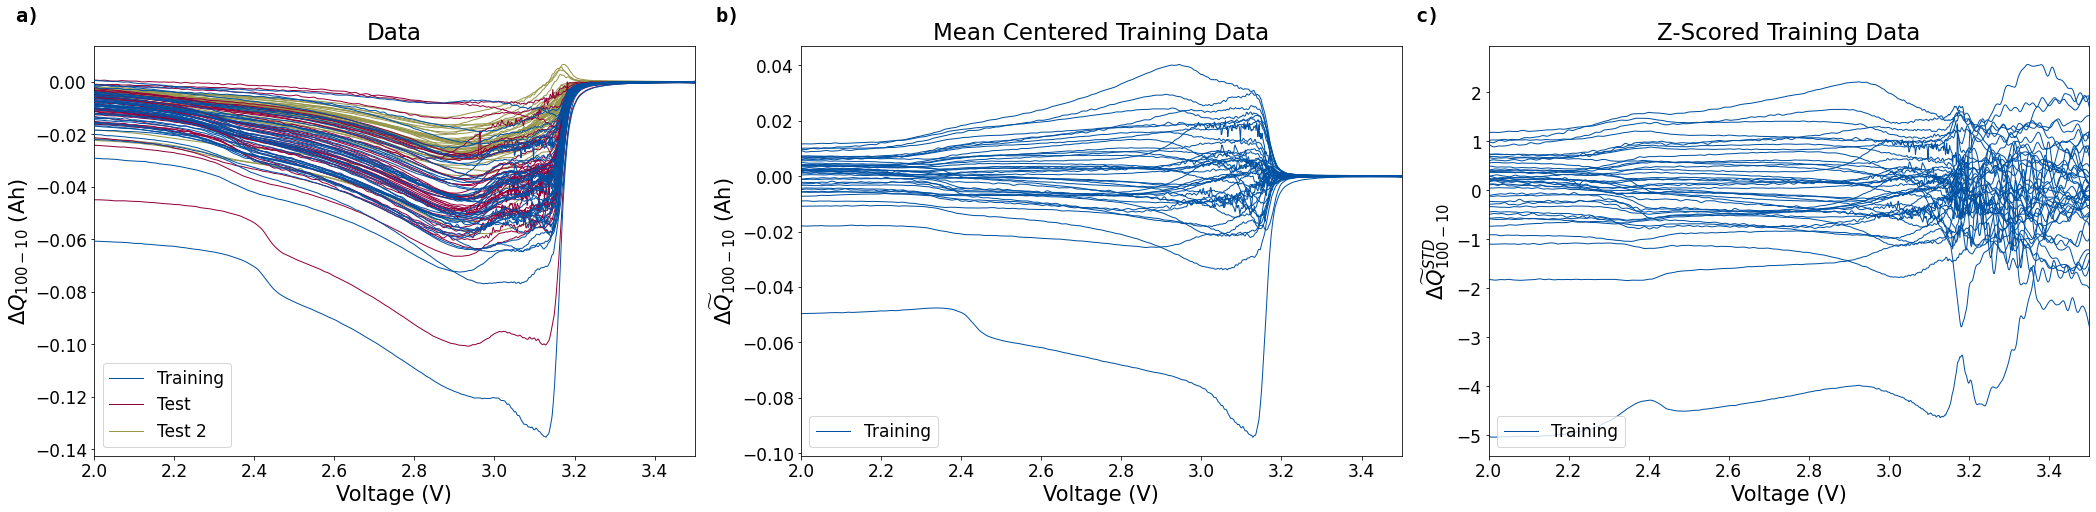

In [7]:
figsize = [29, 7]
fig, ax = plt.subplots(1, 3, figsize=figsize, constrained_layout=True, sharex=True)
x_label = 'Voltage (V)'
y_label = r'$\Delta Q_{100-10}$ (Ah)'
y_label_ = r'$\Delta \widetilde{Q}_{100-10}$ (Ah)'
y_label_std_ = r'$\Delta \widetilde{Q}_{100-10}^{STD}$'
# IBM and other colors!
colors_IBM_ao = ["#0051a2", "#97964a", "#f4777f", "#93003a", "#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000", "#000000"]
ax[0] = plot_x_tt2(X_lfp_train, d_lfp, ax[0], colors_IBM_ao[0], x_label, y_label, zorder=3)
ax[0] = plot_x_tt2(X_lfp_test, d_lfp, ax[0], colors_IBM_ao[3],  x_label, y_label, label_data='Test', zorder=2)
ax[0] = plot_x_tt2(X_lfp_test2, d_lfp, ax[0], colors_IBM_ao[1], x_label, y_label, label_data='Test 2', zorder=1)
ax[0].set_title('Data')
ax[0].set_xlim(2.0, 3.5)


ax[1] = plot_x_tt2(X_lfp_train-np.mean(X_lfp_train, axis=0), d_lfp, ax[1], colors_IBM_ao[0], x_label, y_label_, label_data='Training')
ax[1].set_title('Mean Centered Training Data')
ax[1].set_xlim(2.0, 3.5)

stdx = np.std(X_lfp_train, axis=0)
meanx = np.mean(X_lfp_train, axis=0)
X_ = X_lfp_train - meanx
X_lfp_train_std = X_ / stdx

ax[2] = plot_x_tt2(X_lfp_train_std, d_lfp, ax[2], colors_IBM_ao[0], x_label, y_label_std_, label_data='Training')
ax[2].set_title('Z-Scored Training Data')
ax[2].set_xlim(2.0, 3.5)

trans = mtransforms.ScaledTranslation(-55 / 72, 20 / 72, fig.dpi_scale_trans)
fig, ax[0] = set_axis_label(fig, ax[0], trans, label_str="a)", loc=(-0.04, 1.0))
fig, ax[1] = set_axis_label(fig, ax[1], trans, label_str="b)", loc=(-0.05, 1.0))
fig, ax[2] = set_axis_label(fig, ax[2], trans, label_str="c)", loc=(-0.03, 1.0))

if save_plots:
    plt.savefig(save_plot_path + 'data_lfp.pdf')
plt.show()

# fig, ax = plot_X(X_lfp_train, d_lfp)
# if save_plots: 
#    fig.savefig(save_plot_path + 'TrainingData.pdf') 

/Users/joachim/miniforge3/envs/HD-Feat/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/joachim/miniforge3/envs/HD-Feat/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/joachim/miniforge3/envs/HD-Feat/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/joachim/miniforge3/envs/HD-Feat/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/joachim/miniforge3/envs/HD-Feat/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rco

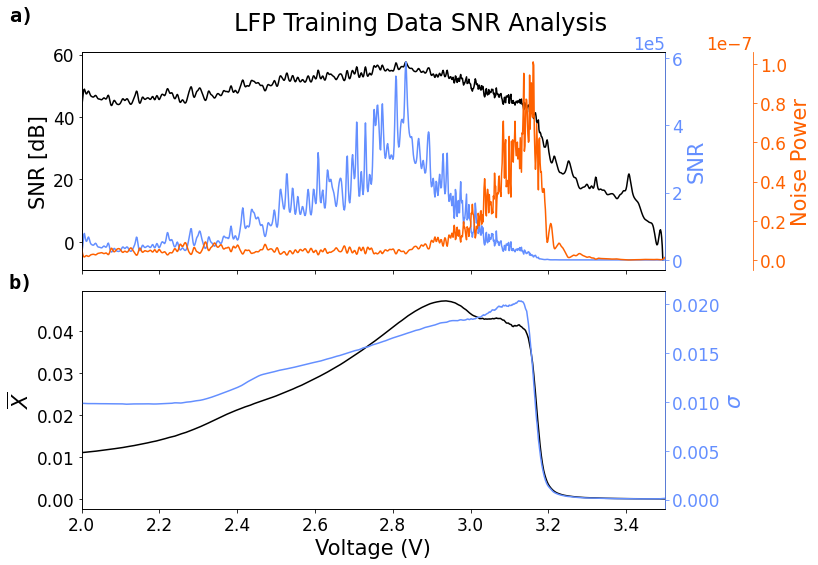

In [8]:
lfp_train_hdata = HD_Data(X_lfp_train, d_lfp, y=[])
fig, ax = lfp_train_hdata.analyze_snr_by_splines(s=1e-5, k=3, mode="X_raw", x_label='Voltage (V)')
# Add axis labels 

# Put a title above the figure
fig.suptitle('LFP Training Data SNR Analysis')
# put figure title higher
fig.subplots_adjust(top=0.91)

trans = mtransforms.ScaledTranslation(-55 / 72, 20 / 72, fig.dpi_scale_trans)
fig, ax[0] = set_axis_label(fig, ax[0], trans, label_str="a)", loc=(-0.03, 1.03))
fig, ax[1] = set_axis_label(fig, ax[1], trans, label_str="b)", loc=(-0.03, 0.9))

if save_plots:
    plt.savefig(save_plot_path + 'SNR_TrainingData.pdf')
# Noise is heteroscedastic, violates the usual assumption!

/Users/joachim/Documents/PhD/02Research/01Papers/03Nullspace/HDFeat/src/hd_data.py:229: RuntimeWarning: invalid value encountered in log10
  self.snr_smooth_dB = savgol_filter(10 * np.log10(snr), window_length, polyorder)


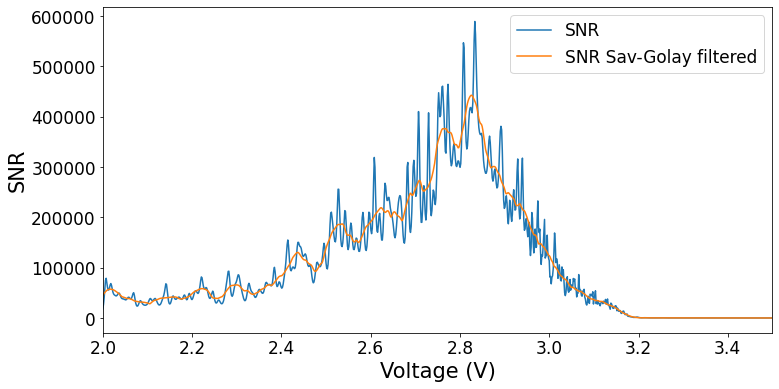

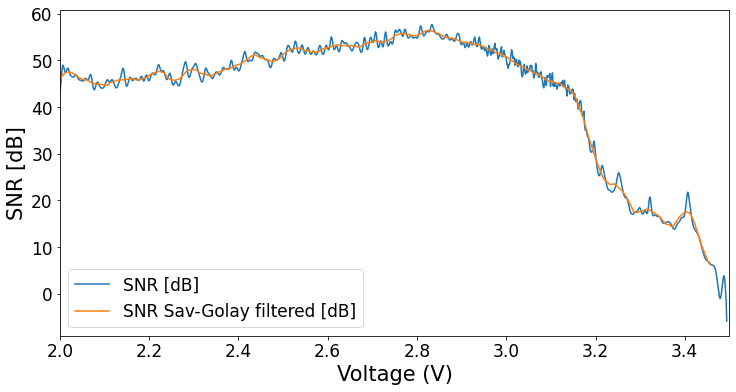

In [9]:

lfp_train_hdata.smooth_snr(window_length=51, polyorder=3)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(lfp_train_hdata.d, lfp_train_hdata.snr, label="SNR")
ax.plot(lfp_train_hdata.d, lfp_train_hdata.snr_smooth, label="SNR Sav-Golay filtered")
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('SNR')
ax.set_xlim(2.0, 3.5)
ax.legend()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(lfp_train_hdata.d, lfp_train_hdata.snr_dB, label="SNR [dB]")
ax.plot(lfp_train_hdata.d, lfp_train_hdata.snr_smooth_dB, label="SNR Sav-Golay filtered [dB]")
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('SNR [dB]')
ax.set_xlim(2.0, 3.5)
ax.legend()
plt.show()

# Save the snr_smooth_dB to csv (it is a numpy array)
np.savetxt("data/lfp_snr_smooth_dB.csv", lfp_train_hdata.snr_smooth_dB, delimiter=",")
np.savetxt("data/lfp_snr_smooth.csv", lfp_train_hdata.snr_smooth, delimiter=",")

In [10]:
y_lfp_train_syn = np.zeros(X_lfp_train.shape[0])
mean_function = lambda a: np.mean(a)
mean_reg_coef_lfp = (1/X_lfp_train.shape[1]) * np.ones(X_lfp_train.shape[1])

if not load_data: 
    y_lfp_train_mean_function = construct_y_data(X_lfp_train, mean_function, per_range=[0,1])
    data_lfp_mean = HD_Data(X=X_lfp_train, d=d_lfp, y=y_lfp_train_mean_function)
    data_lfp_mean = data_lfp_mean.add_wgn(snr_y=50)

    if save_data: 
        np.savetxt(
            data_path + 'lfp_y_mean.csv', data_lfp_mean.y, delimiter=",", 
            header='Sample Mean reposne for the LFP Data')
else:
    y=np.loadtxt(data_path + 'lfp_y_mean.csv', skiprows=1, delimiter=',')
    data_lfp_mean = HD_Data(X=X_lfp_train, d=d_lfp, y=y)

## LFP dataset synthethic y

In [11]:

nulls_lfp_mean = Nullspace(data_lfp_mean)
nulls_lfp_mean = nulls_lfp_mean.learn_weights(models, model_names)
nulls_lfp_mean.set_standardization(std=False)

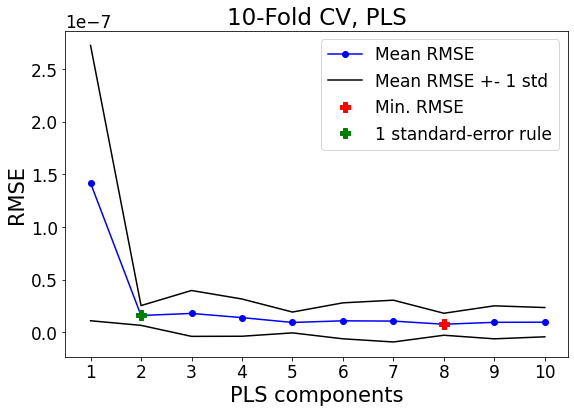

{'rmse_vals': array([1.41710341e-07, 1.60044265e-08, 1.79537966e-08, 1.39695960e-08,
        9.37500391e-09, 1.09340506e-08, 1.06839772e-08, 7.68231938e-09,
        9.50886078e-09, 9.63944282e-09]),
 'components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 'rmse_std_min': 1,
 'l2_distance': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [12]:
optimize_pls_cv(data_lfp_mean.X_, data_lfp_mean.y_, max_comps=10, plot_components=True, std=False)

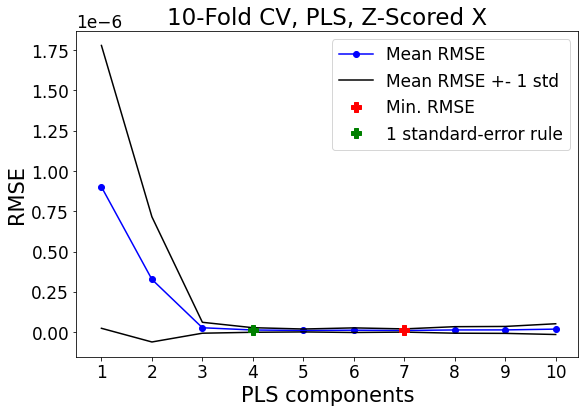

{'rmse_vals': array([9.01133511e-07, 3.27362171e-07, 2.74400638e-08, 1.35669929e-08,
        1.05880301e-08, 1.23376486e-08, 1.04275365e-08, 1.38797029e-08,
        1.40837453e-08, 1.89388895e-08]),
 'components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 'rmse_std_min': 3,
 'l2_distance': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [13]:
optimize_pls_cv(data_lfp_mean.X_, data_lfp_mean.y_, max_comps=10, plot_components=True, std=True)

Constraint value: 0.010000100022, Method NRMSE


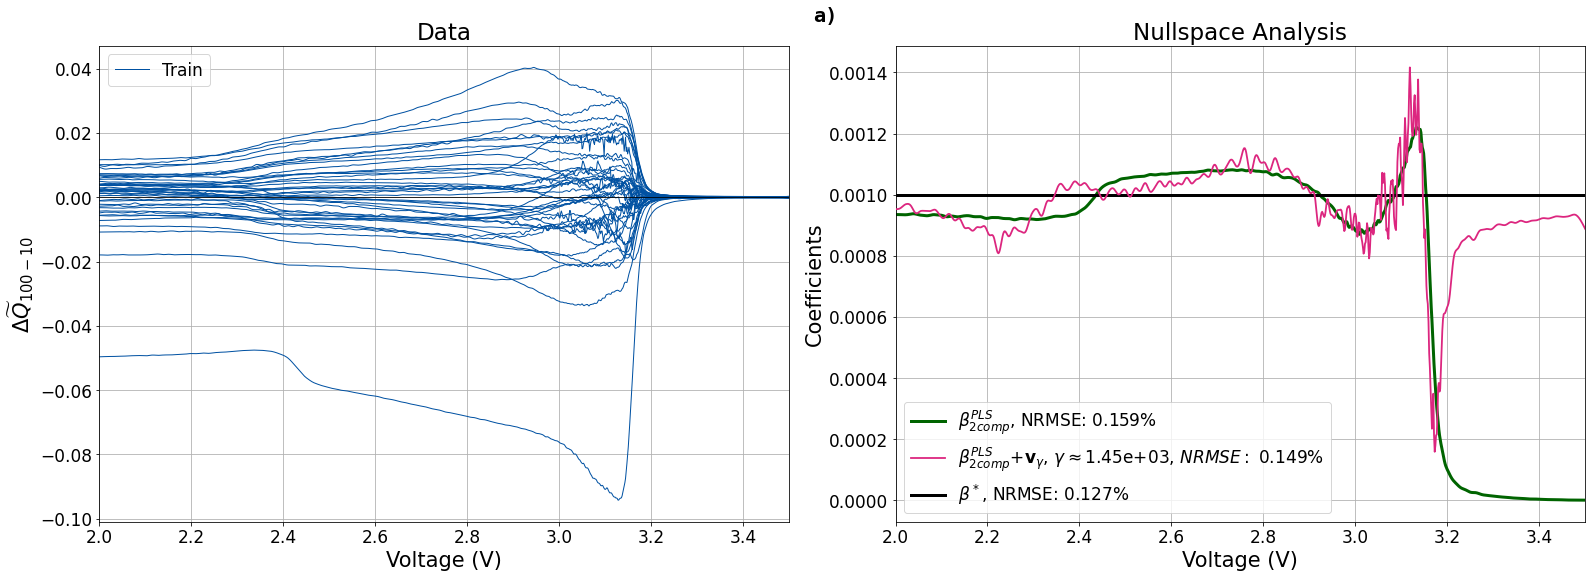

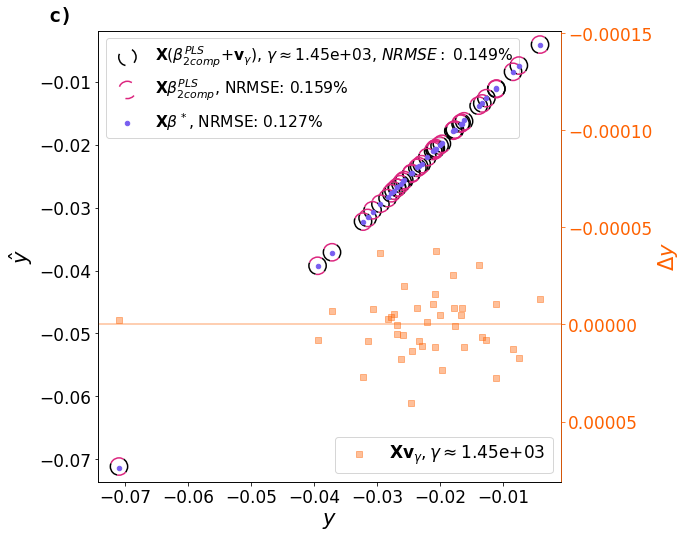

In [14]:
nulls_lfp_mean.set_standardization(std=False)
nulls_lfp_mean.set_nullspace_weights(
    key_alpha = 'PLS 2 Comp.', 
    w_alpha_name=r'$\beta_{2 comp}^{PLS}$',
    w_beta = mean_reg_coef_lfp, 
    w_beta_name=r'$\beta^*$'
    )

nulls_lfp_mean, fig, ax = nulls_lfp_mean.nullspace_analysis(
    plot_results=True, 
    save_plot=0,
    opt_gamma_method='NRMSE',
    con_thres=0.01,
    nullspace_path = False,
    ax_labelstr = ("", "a)"),
    )


ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[0].set_xlabel('Voltage (V)')
ax[1].set_xlabel('Voltage (V)')    
ax[1].legend(loc=3)
plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_example_2PLS_mean.pdf')

nulls_lfp_mean.scatter_predictions()

Constraint value: 0.010000099982, Method NRMSE


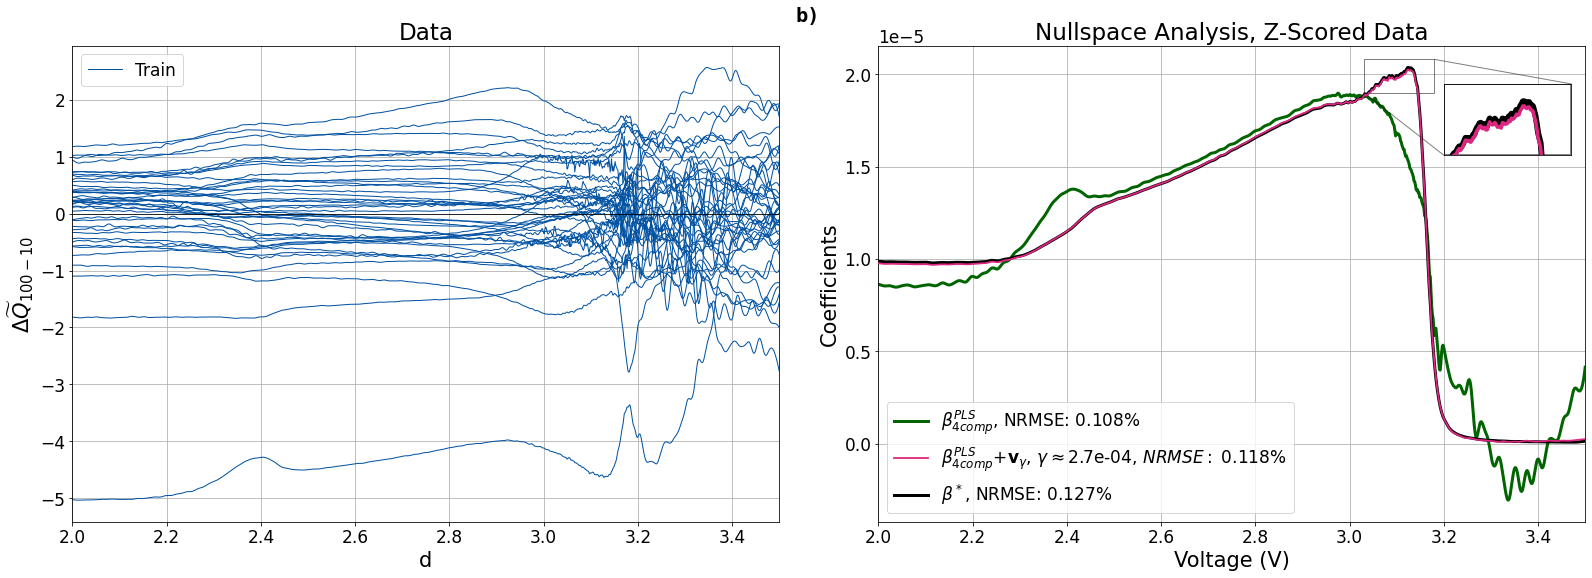

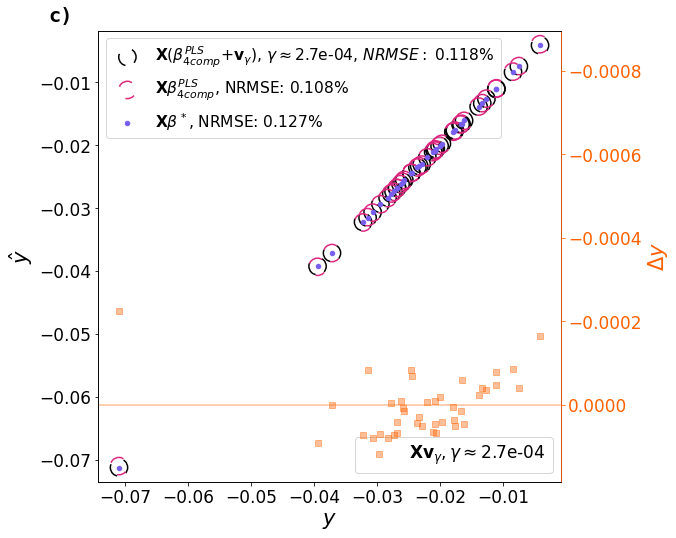

In [15]:
nulls_lfp_mean.set_standardization(std=True)

nulls_lfp_mean.set_nullspace_weights(
    key_alpha = 'PLS 4 Comp.', 
    w_alpha_name=r'$\beta_{4 comp}^{PLS}$',
    w_beta = mean_reg_coef_lfp, 
    w_beta_name=r'$\beta^*$',
    )

nulls_lfp_mean, fig, ax = nulls_lfp_mean.nullspace_analysis(
    plot_results=True,
    save_plot=0,
    opt_gamma_method='NRMSE',
    con_thres=0.01,
    nullspace_path = False,
    ax_labelstr = ("", "b)"),
    inset_axes_ce = [0.8, 0.77, 0.18, 0.15],
    zoom_coords = [3.03, 3.18, 1e-5*1.9, 1e-5*2.08],
    )

ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')   
ax[1].set_title('Nullspace Analysis, Z-Scored Data')
ax[1].legend(loc=3)
plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_example_std_4PLS_mean.pdf')


nulls_lfp_mean.scatter_predictions()

## Colum mean weights

In [16]:
# Contruct data object
# data LFP Synthethic YTrue repsonse is X@column_mean 

rcoef_lfp_cm =  np.mean(X_lfp_train, axis=0)

if not load_data: 
    y_lfps_train_cm = np.dot(X_lfp_train, rcoef_lfp_cm)

    dml_lfps_cm = HD_Data(X=X_lfp_train, d=d_lfp, y=y_lfps_train_cm)
    # Add noise to target values
    dml_lfps_cm = dml_lfps_cm.add_wgn(snr_y=50)
    if save_data: 
        np.savetxt(
            data_path + 'lfp_y_cm.csv', dml_lfps_cm.y, delimiter=',', 
            header='Column Mean response for the LFP Data')
else:
    y=np.loadtxt(data_path + 'lfp_y_cm.csv', skiprows=1, delimiter=',')
    dml_lfps_cm = HD_Data(X=X_lfp_train, d=d_lfp, y=y)

nulls_lfp_cm = Nullspace(dml_lfps_cm)
nulls_lfp_cm = nulls_lfp_cm.learn_weights(models, model_names)

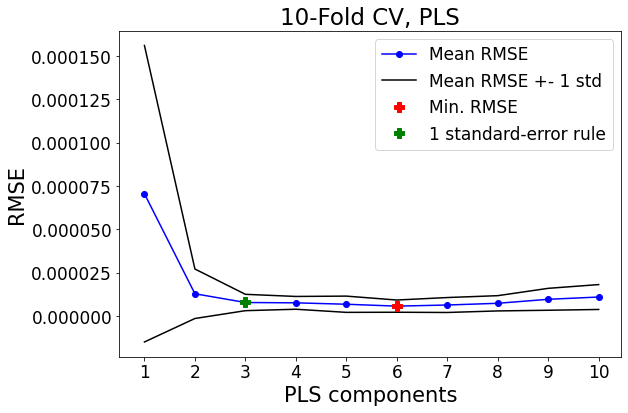

{'rmse_vals': array([7.06231051e-05, 1.29164070e-05, 7.87486197e-06, 7.67211286e-06,
        6.86982697e-06, 5.77386524e-06, 6.42430136e-06, 7.40929881e-06,
        9.72125591e-06, 1.10281926e-05]),
 'components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 'rmse_std_min': 2,
 'l2_distance': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [17]:
optimize_pls_cv(dml_lfps_cm.X_, dml_lfps_cm.y_, max_comps=10, plot_components=True, std=False)

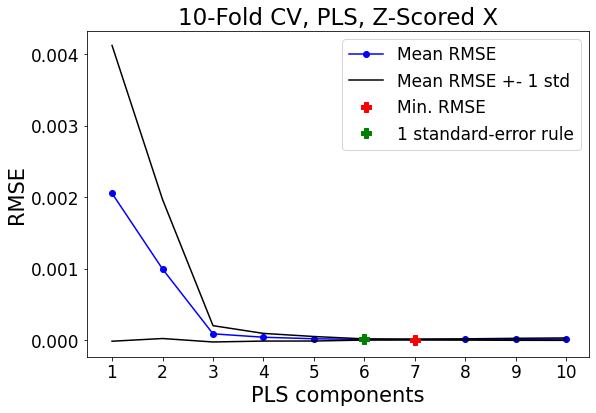

{'rmse_vals': array([2.05462372e-03, 9.97192183e-04, 9.12253853e-05, 4.34543504e-05,
        2.21728222e-05, 1.22813258e-05, 1.16580890e-05, 1.23505581e-05,
        1.44912669e-05, 1.68009043e-05]),
 'components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 'rmse_std_min': 5,
 'l2_distance': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [18]:
optimize_pls_cv(dml_lfps_cm.X_, dml_lfps_cm.y_, max_comps=10, plot_components=True, std=True)

Constraint value: 0.005000100000, Method NRMSE


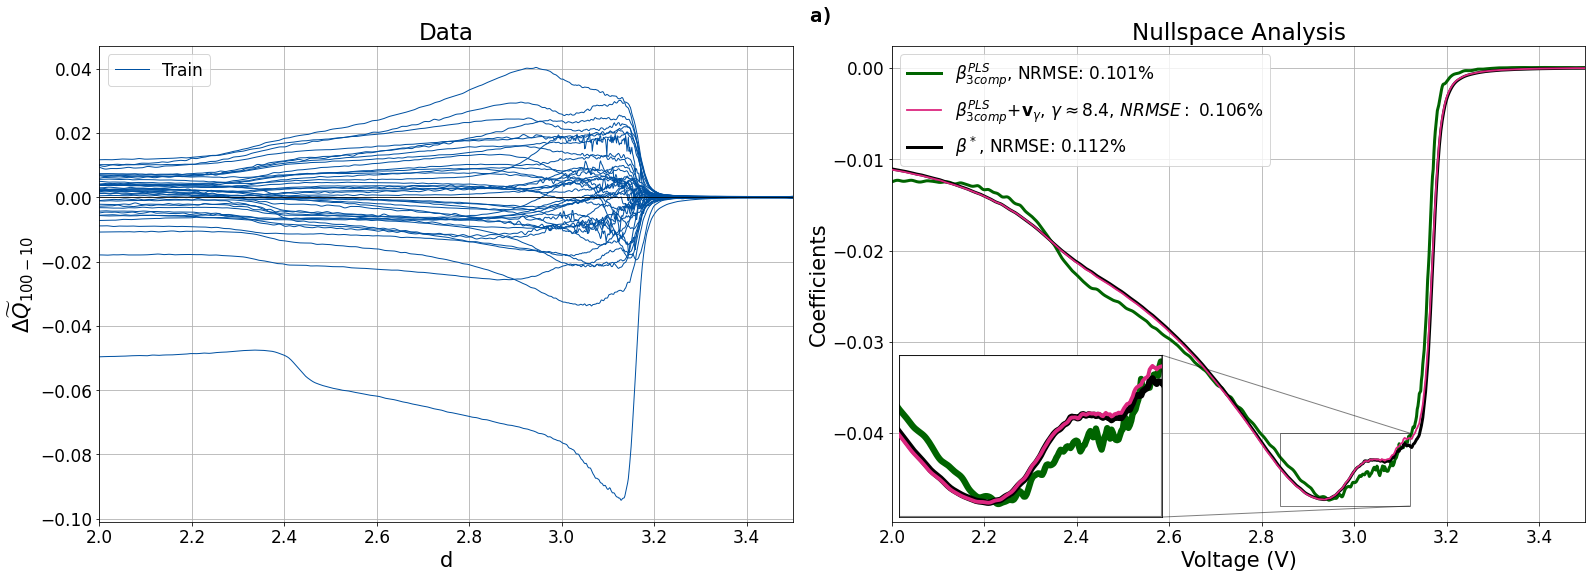

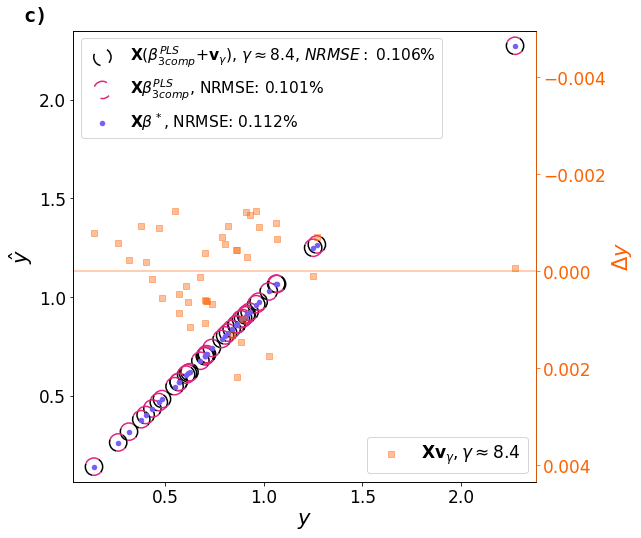

In [19]:
nulls_lfp_cm.set_standardization(std=False)
nulls_lfp_cm.set_nullspace_weights(
    key_alpha = 'PLS 3 Comp.', 
    w_alpha_name=r'$\beta_{3 comp}^{PLS}$',
    w_beta = rcoef_lfp_cm, 
    w_beta_name=r'$\beta^*$',
    )

nulls_lfp_cm, fig, ax = nulls_lfp_cm.nullspace_analysis(
    plot_results=True,
    save_plot=0,
    opt_gamma_method='NRMSE',
    con_thres=0.005,
    nullspace_path = False,
    ax_labelstr = ("", "a)"),
    inset_axes_ce = [0.01, 0.01, 0.38, 0.34],
    zoom_coords = [2.84, 3.12, -0.048, -0.04],
    )
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')    

plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_3PLS_cm.pdf')


nulls_lfp_cm.scatter_predictions()

Constraint value: 0.005000099998, Method NRMSE


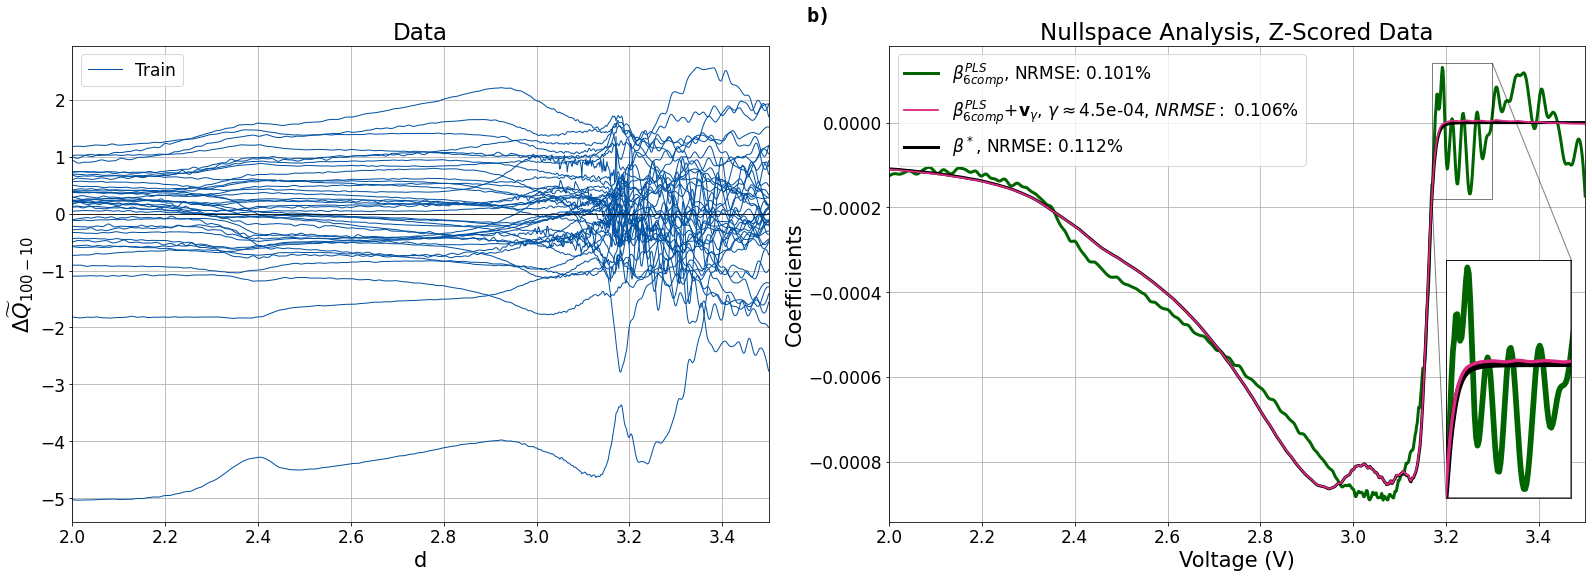

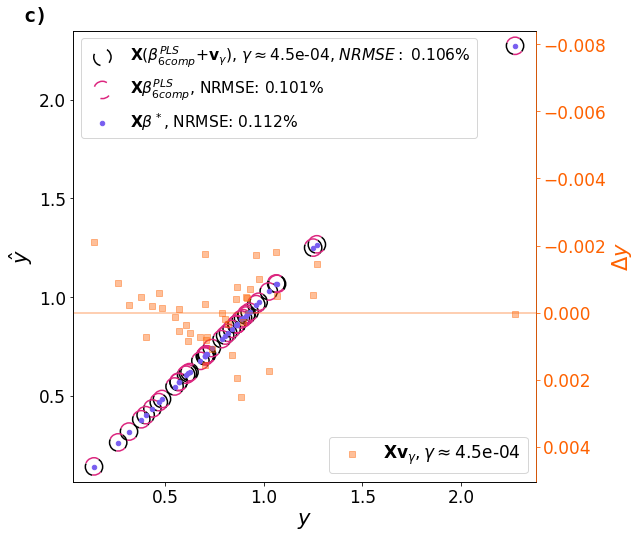

In [20]:
nulls_lfp_cm.set_standardization(std=True)
nulls_lfp_cm.set_nullspace_weights(
    key_alpha = 'PLS 6 Comp.', 
    w_alpha_name=r'$\beta_{6 comp}^{PLS}$',
    w_beta = rcoef_lfp_cm, 
    w_beta_name=r'$\beta^*$',
    )

nulls_lfp_cm, fig, ax = nulls_lfp_cm.nullspace_analysis(
    plot_results=True,
    save_plot=0,
    opt_gamma_method='NRMSE',
    con_thres=0.005,
    nullspace_path = False,
    ax_labelstr = ("", "b)"),
    inset_axes_ce = [0.8, 0.05, 0.18, 0.5],
    zoom_coords = [3.17, 3.3, -0.00018, 0.00014],
    )
    
ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[1].set_xlabel('Voltage (V)')    
ax[1].set_title('Nullspace Analysis, Z-Scored Data')

plt.show()
if save_plots: 
    fig.savefig(save_plot_path + 'LFP_6PLS_cm_std.pdf')


nulls_lfp_cm.scatter_predictions()

## Cycle Life Response

In [21]:
# Run a proper crossvalidation study wiht PLS and cycle life response. 
# MAybe iunclude the rr result sin the supplementary infromation. 
# Compare the crossva;lidaiton results with peter attai sta tlearning paper.

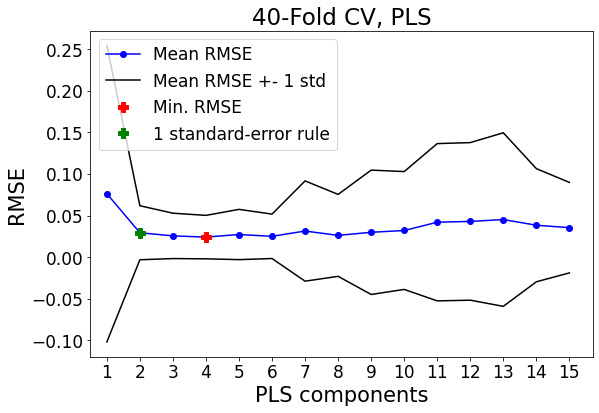

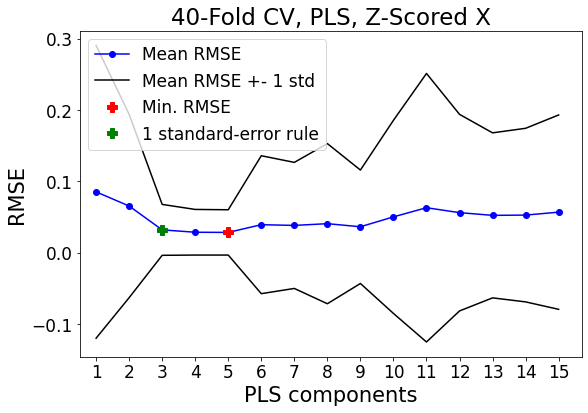

exception calling callback for <Future at 0x28ef0f0a0 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/joachim/miniforge3/envs/HD-Feat/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/Users/joachim/miniforge3/envs/HD-Feat/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'neg_mse_exp_y_scorer' on <module 'utils' from '/Users/joachim/Documents/PhD/02Research/01Papers/03Nullspace/HDFeat/src/utils.py'>
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/joachim/miniforge3/envs/HD-Feat/lib/python3.10/site-packages/joblib/externals/loky/_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "/Users/joac

In [33]:
# Set random seed for reproducibility
random.seed(40)
np.random.seed(40)


stdx = np.std(X_lfp_train, axis=0)
meanx = np.mean(X_lfp_train, axis=0)
X_ = X_lfp_train - meanx
X_lfp_train_std = X_ / stdx
y_log_cl = np.log(y_cl_train).copy()
y_cl = y_cl_train
y_log_cl_ = y_log_cl - np.mean(y_log_cl)


# Optimize the number of components for the PLS model based on standardized data and not standardized data.
cv_dict = optimize_pls_cv(X_, y_log_cl, max_comps=12, folds=10, plot_components=True, std=False, neg_rmse_exp_scorer=False)
cv_dict_pls_std = optimize_pls_cv(X_, y_log_cl, max_comps=12, folds=10, plot_components=True, std=True, neg_rmse_exp_scorer=False)

cv_dict = optimize_pls_cv(X_, y_log_cl, max_comps=12, folds=10, plot_components=True, std=False, neg_rmse_exp_scorer=True)
cv_dict_pls_std = optimize_pls_cv(X_, y_log_cl, max_comps=12, folds=10, plot_components=True, std=True, neg_rmse_exp_scorer=True)



In [24]:
dml_lfps_cl = HD_Data(X=X_lfp_train, d=d_lfp, y=y_log_cl)
nulls_lfp_cl = Nullspace(dml_lfps_cl)
nulls_lfp_cl = nulls_lfp_cl.learn_weights(models, model_names)

In [25]:
def vis_reg_coef(
    *,
    beta: np.ndarray,
    d: np.ndarray,
    y: np.ndarray,
    label: dict = None,
    fig = None, 
    ax = None,
    cid=0,
    return_fig: bool = True,
    
    **kwargs,
) :
    """Plot the nullspace correction"""
    y = y - np.mean(y)
    color_list = ["darkgreen", "#0051a2", "#97964a", "#f4777f", "#93003a"]
    if ax is None:
        figsize = [11, 8]
        fig, ax = plt.subplots(1, 1, figsize=figsize, constrained_layout=True)

    # markevery = int(len(x) / 15)
    ax.plot(
        d,
        beta,
        label=label,
        color=color_list[cid],
        linewidth=3,
    )

    ax.set_xlim(min(d), max(d))

    #ax.set_title("Regression Coefficients")
    ax.grid(zorder=1)
    ax.legend(loc=2)

    if return_fig:
        return fig, ax
    else:
        plt.show()
        return None

In [26]:
y_cl_train

array([2160., 1434., 1074.,  870.,  788.,  719.,  857.,  788.,  559.,
       1017.,  870.,  860.,  709.,  731.,  742.,  704.,  617.,  966.,
        702.,  616.,  300.,  438.,  444.,  511.,  477.,  483.,  494.,
        461.,  489.,  527.,  461.,  468.,  498.,  492.,  520.,  463.,
        478.,  459.,  429.,  462.,  487.])

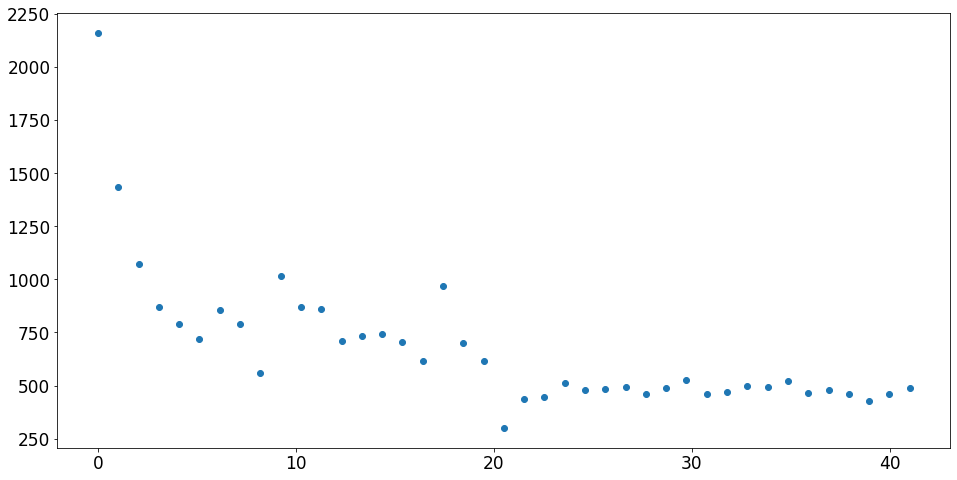

In [27]:
plt.scatter(np.linspace(0, len(y_cl_train), len(y_cl_train)), y_cl_train)

In [28]:
# Load file 
file_name = "regression_in_R/lfp_cl_D1_cv_reg_coeff.csv"
reg_coef_d1 = pd.read_csv(file_name, index_col=0)

file_name = "regression_in_R/lfp_cl_D2_cv_reg_coeff.csv"
reg_coef_d2 = pd.read_csv(file_name, index_col=0)

file_name = "regression_in_R/lfp_cl_D1_std_cv_reg_coeff.csv"
reg_coef_d1_std = pd.read_csv(file_name, index_col=0)

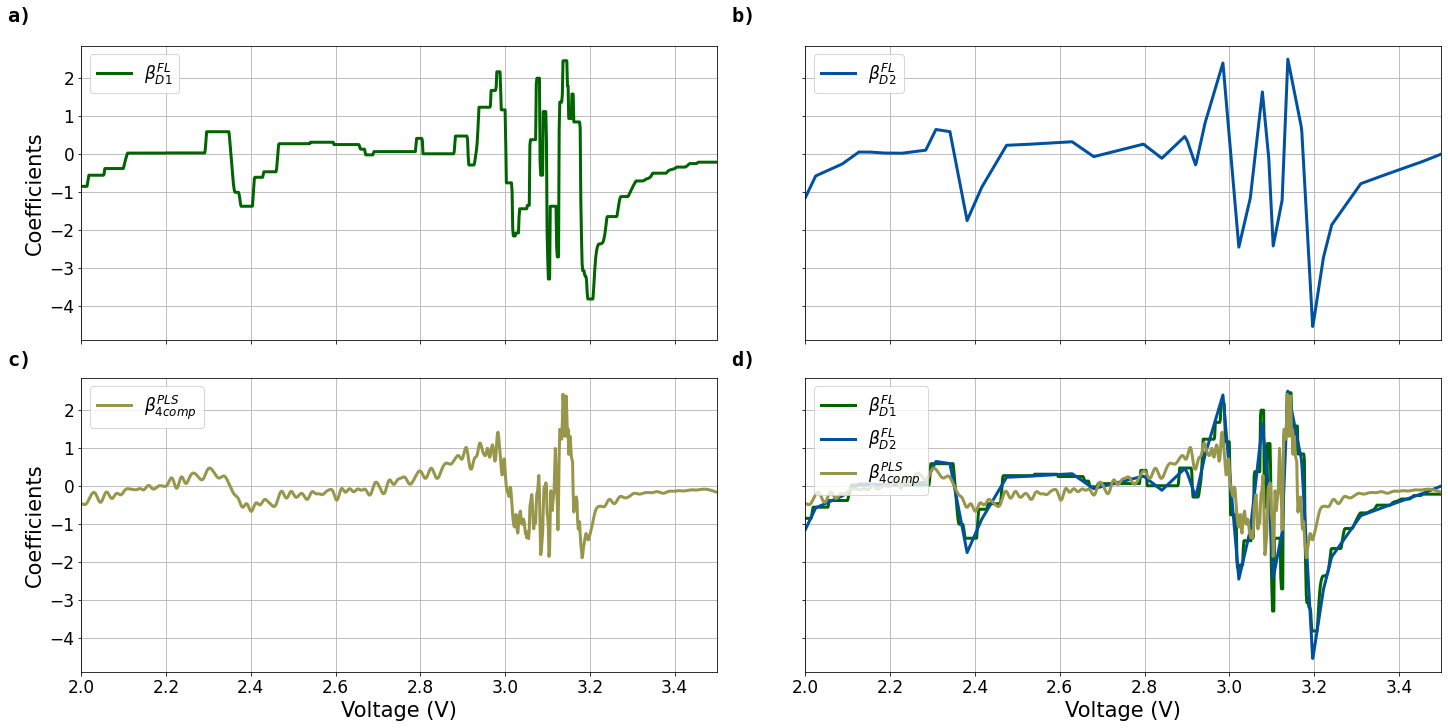

In [29]:
figsize = [20, 10]
fig, ax = plt.subplots(2, 2, figsize=figsize, constrained_layout=True, sharex=True, sharey=True)

fig, ax[0, 0] = vis_reg_coef(
    beta = reg_coef_d1.iloc[:, 1],
    d = np.linspace(2.0, 3.5, 1000),
    y = y_log_cl,
    label = r"$\beta_{D1}^{FL}$",
    fig = fig, 
    ax = ax[0, 0],
    cid=0)

fig, ax[0, 1] = vis_reg_coef(
    beta = reg_coef_d2.iloc[:, 1],
    d = np.linspace(2.0, 3.5, 1000),
    y = y_log_cl,
    label = r"$\beta_{D2}^{FL}$",
    fig = fig, 
    ax = ax[0, 1],
    cid=1)

fig, ax[1, 0] = vis_reg_coef(
    beta = nulls_lfp_cl.weights['PLS 6 Comp.'],
    d = np.linspace(2.0, 3.5, 1000),
    y = y_log_cl,
    label = r"$\beta_{4 comp}^{PLS}$",
    fig = fig, 
    ax = ax[1, 0],
    cid=2)

fig, ax[1, 1] = vis_reg_coef(
    beta = reg_coef_d1.iloc[:, 1],
    d = np.linspace(2.0, 3.5, 1000),
    y = y_log_cl,
    label = r"$\beta_{D1}^{FL}$",
    fig = fig, 
    ax = ax[1, 1],
    cid=0)

fig, ax[1, 1] = vis_reg_coef(
    beta = reg_coef_d2.iloc[:, 1],
    d = np.linspace(2.0, 3.5, 1000),
    y = y_log_cl,
    label = r"$\beta_{D2}^{FL}$",
    fig = fig, 
    ax = ax[1, 1],
    cid=1)

fig, ax[1, 1] = vis_reg_coef(
    beta = nulls_lfp_cl.weights['PLS 6 Comp.'],
    d = np.linspace(2.0, 3.5, 1000),
    y = y_log_cl,
    label = r"$\beta_{4 comp}^{PLS}$",
    fig = fig, 
    ax = ax[1, 1],
    cid=2)


trans = mtransforms.ScaledTranslation(-55 / 72, 20 / 72, fig.dpi_scale_trans)
fig, ax[0,0] = set_axis_label(fig, ax[0,0], trans, label_str="a)", loc=(-0.03, 1.0))
fig, ax[0,1] = set_axis_label(fig, ax[0,1], trans, label_str="b)", loc=(-0.03, 1.0))
fig, ax[1,0] = set_axis_label(fig, ax[1,0], trans, label_str="c)", loc=(-0.03, 0.96))
fig, ax[1,1] = set_axis_label(fig, ax[1,1], trans, label_str="d)", loc=(-0.03, 0.96))

ax[1,0].set_xlabel("Voltage (V)")
ax[1,1].set_xlabel("Voltage (V)")
ax[0,0].set_ylabel("Coefficients")
ax[1,0].set_ylabel("Coefficients")
#fig.suptitle("Cross-Validate Generalized Lasso Regression Coefficients")

# Save figure
if save_plots:
    plt.savefig(save_plot_path + 'LFP_CL_CV_Reg_Coeff_genlasso.pdf')

IndexError: single positional indexer is out-of-bounds

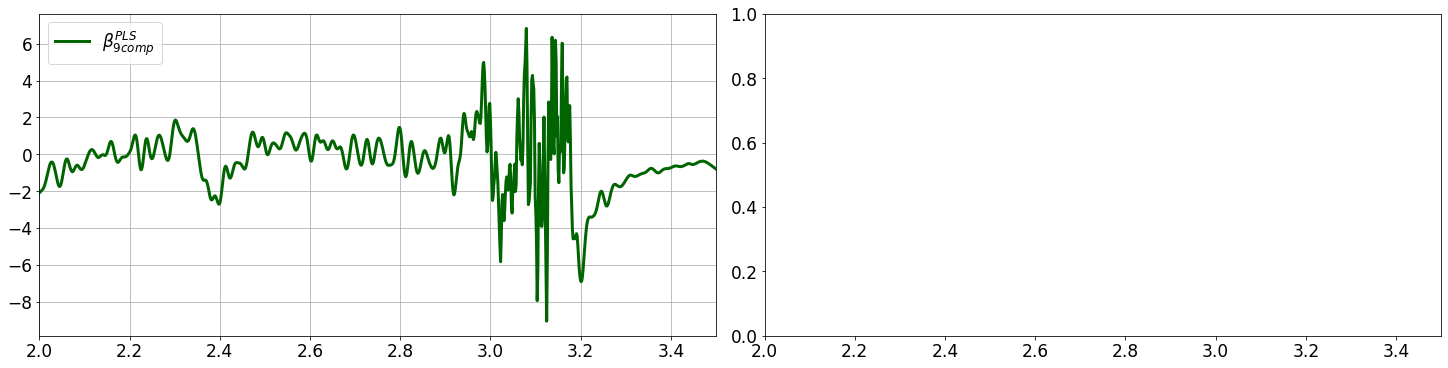

In [30]:
figsize = [20, 5]
fig, ax = plt.subplots(1, 2, figsize=figsize, constrained_layout=True, sharex=True, sharey=False)

fig, ax[0] = vis_reg_coef(
    beta = nulls_lfp_cl.weights['PLS 9 Comp.'],
    d = np.linspace(2.0, 3.5, 1000),
    y = y_log_cl,
    label = r"$\beta_{9comp}^{PLS}$",
    fig = fig, 
    ax = ax[0],
    cid=0)

fig, ax[1] = vis_reg_coef(
    beta = reg_coef_d1_std.iloc[:, 4],
    d = np.linspace(2.0, 3.5, 1000),
    y = y_log_cl,
    label = r"$\beta_{D1}^{FL}$ Z-Scored Data",
    fig = fig, 
    ax = ax[1],
    cid=1)

trans = mtransforms.ScaledTranslation(-55 / 72, 20 / 72, fig.dpi_scale_trans)
fig, ax[0] = set_axis_label(fig, ax[0], trans, label_str="a)", loc=(-0.03, 1.0))
fig, ax[1] = set_axis_label(fig, ax[1], trans, label_str="b)", loc=(-0.03, 1.0))

ax[0].set_xlabel("Voltage (V)")
ax[1].set_xlabel("Voltage (V)")
ax[0].set_ylabel("Coefficients")
#fig.suptitle("Cross-Validate Generalized Lasso Regression Coefficients")

# Save figure
if save_plots:
    plt.savefig(save_plot_path + 'LFP_CL_CV_Reg_Coeff_PLS_genlasso_std.pdf')

In [ ]:
# Use nulls_lfp_cl.weights['PLS 4 Comp.'] to make prediction of the training and test set 
# and compare to the true values.
# Load the LFP Dataset
lfp_df = pd.read_csv(data_path + 'lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])    
X_lfp = X_lfp[:, ::-1]
y_cl = np.array(lfp_df.iloc[:, 1000])
d_lfp = np.linspace(2.0, 3.5, 1000)

X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_cl_train = np.array(y_cl[lfp_df.iloc[:, 1002]==0])
X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
y_cl_test = np.array(y_cl[lfp_df.iloc[:, 1002]==1])
X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
y_cl_test2 = np.array(y_cl[lfp_df.iloc[:, 1002]==2])

# Remove the smallest value in the test set (base on y_cl_test)
id_outlier_test = np.where(y_cl_test==np.min(y_cl_test))
X_lfp_test = np.delete(X_lfp_test, id_outlier_test, axis=0)
y_cl_test = np.delete(y_cl_test, id_outlier_test, axis=0)

stdx = np.std(X_lfp_train, axis=0)
meanx = np.mean(X_lfp_train, axis=0)
X_ = X_lfp_train - meanx
X_lfp_train_std = X_ / stdx

X_test1_ = X_lfp_test - meanx
X_test1_std = X_test1_ / stdx
X_test2_ = X_lfp_test2 - meanx
X_test2_std = X_test2_ / stdx

nulls_lfp_cl.set_standardization(std=False)
nulls_lfp_cl = nulls_lfp_cl.learn_weights(models, model_names)

nulls_lfp_cl.set_standardization(std=True)
nulls_lfp_cl = nulls_lfp_cl.learn_weights(models, model_names)

In [ ]:
def predict_LFP_based_on_coef(Xtr, Xt1, Xt2, y, y_test, y_test2, coef, y_mean):

    y_pred_train = np.exp(np.dot(Xtr, coef) + y_mean)
    y_pred_test1 = np.exp(np.dot(Xt1, coef) + y_mean)
    y_pred_test2 = np.exp(np.dot(Xt2, coef) + y_mean)

    # Get the RMSE Errors
    rmse_train = np.sqrt(np.mean((y_pred_train - y)**2))
    rmse_test1 = np.sqrt(np.mean((y_pred_test1 - y_test)**2))
    rmse_test2 = np.sqrt(np.mean((y_pred_test2 - y_test2)**2))
    print("RMSE Train: ", rmse_train)
    print("RMSE Test 1: ", rmse_test1)
    print("RMSE Test 2: ", rmse_test2)
    return None

In [ ]:
print("PLS 3 Comp. Not Standardized")
predict_LFP_based_on_coef(X_, X_test1_, X_test2_, y_cl_train, y_cl_test, y_cl_test2, nulls_lfp_cl.weights['PLS 3 Comp.'], np.mean(y_log_cl))

print("PLS 9 Comp. Standardized")
predict_LFP_based_on_coef(X_lfp_train_std, X_test1_std, X_test2_std, y_cl_train, y_cl_test, y_cl_test2, nulls_lfp_cl.weights['PLS 9 Comp. std'], np.mean(y_log_cl))



RMSE Train:  109.31107818221426
RMSE Test 1:  128.41661979018113
RMSE Test 2:  200.88343017053504
RMSE Train:  56.181939984019294
RMSE Test 1:  98.55389762955687
RMSE Test 2:  174.8522319616899


In [ ]:
nulls_lfp_cl.weights['PLS 9 Comp. std'].shape

(1000,)

In [ ]:
reg_coef_d1_std.iloc[:, 4].shape

(1000,)

In [ ]:
np.mean(y_log_cl)

6.433353436588338

In [ ]:
predict_LFP_based_on_coef(X_, X_test1_, X_test2_, y_cl_train, y_cl_test, y_cl_test2, reg_coef_d1_std.iloc[:, 4], np.mean(y_log_cl))

RMSE Train:  312.4404037477712
RMSE Test 1:  382.8876265223189
RMSE Test 2:  481.9975990621985


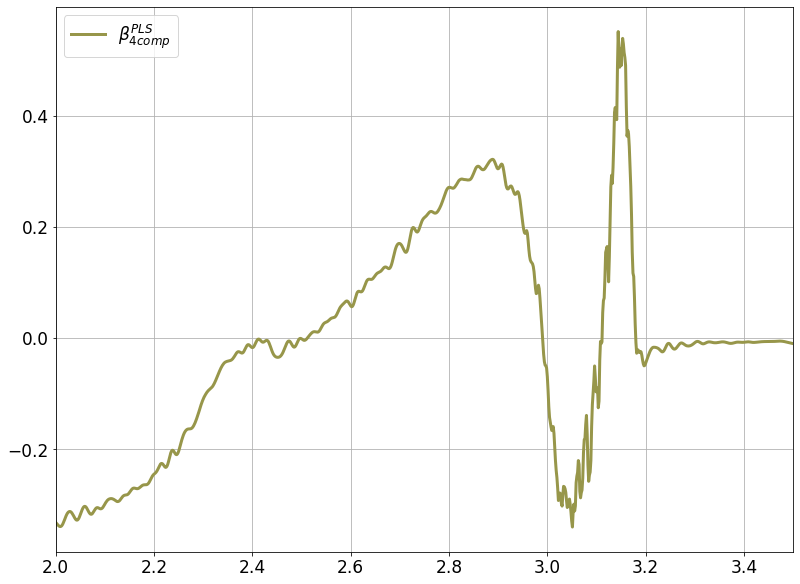

In [ ]:
fig, ax = vis_reg_coef(
    beta = nulls_lfp_cl.weights['PLS 4 Comp.'],
    d = np.linspace(2.0, 3.5, 1000),
    y = y_log_cl,
    label = r"$\beta_{4comp}^{PLS}$",
    fig = None, 
    ax = None,
    cid=2)

In [ ]:
# TODO:
# Include table in latex with the prediction accouracies. 

# Choose very difefrent ones for comparison. 

In [ ]:
# TODO: Fiz this cell

nulls_lfp_cl.set_standardization(std=False)
nulls_lfp_cl.set_nullspace_weights(
    key_alpha = 'PLS 2 Comp.', 
    w_alpha_name=r'$\beta_{2 comp}^{PLS}$',
    w_beta = 'PLS 3 Comp.', 
    w_beta_name=r'$\beta^*$'
    )

nulls_lfp_cl, fig, ax = nulls_lfp_cl.nullspace_analysis(
    plot_results=True, 
    save_plot=0,
    opt_gamma_method='NRMSE',
    con_thres=0.01,
    nullspace_path = False,
    ax_labelstr = ("", "a)"),
    )


ax[0].set_ylabel(r'$\Delta \widetilde{Q}_{100-10}$')
ax[0].set_xlabel('Voltage (V)')
ax[1].set_xlabel('Voltage (V)')    
ax[1].legend(loc=3)
plt.show()
#if save_plots: 
#    fig.savefig(save_plot_path + 'LFP_example_2PLS_mean.pdf')

nulls_lfp_mean.scatter_predictions()

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U11'), dtype('float64')) -> None

In [ ]:
len(y_cl)

124

0.3720378256991779